In [1]:
# __author__ = 'Prakhar MISRA'
# Created 05/14/2020
# Last edit 05/14/2020
'''
#Purpose:
#-----------------
1. TO Google coal generation 

Reference:


# EDIT History
the data is NO2 tropospheric, cloud screened at 0.3 (check the giovanni docs again)
orignal unit is molecules/cm2
empty is xx*10(^30)

#Output expected:
#-----------------
# OMI trend (2015 - 2019)


#Terminology used:
#-----------------
#       
#       
'''

from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os.path
import datetime
from functools import reduce
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from  glob import glob
import multiprocessing as mp
#import rasterio

#%matplotlib notebookn
import helpers.fn_readPOSOCOpdf as rpp


currdir = os.getcwd()


# whole north india
North Indian aggregated data from Robbie Anrew http://folk.uio.no/roberan/t/POSOCO.shtml 


In [2]:
# North Indian aggregated data from Robbie Anrew http://folk.uio.no/roberan/t/POSOCO.shtml 

def read_csv(Coal_path):
    df = pd.read_csv(Coal_path)
    df["date"] = pd.to_datetime(df["yyyymmdd"], format = "%Y%m%d")
    df["year"] = df["date"].dt.year
    df["doy"] = df["date"].dt.dayofyear
    df["month"] = df["date"].dt.month
    df["week"] = df["date"].dt.week
    df = df.set_index("date")
    
    return df


Coal_path = os.path.join(currdir, "Data", "Emission", "POSOCO_data.csv")
SPECIES = "OMNO2d"
    
# read the csv
df_GM = read_csv(Coal_path)

StartDate = datetime.datetime(2015, 1, 1)
# there is also double counting of weeks at then end or start of year. need to get rid of them by making an indicator for weeks since 2015-01-01.
df_GM["days_since"] = (df_GM.index - StartDate)
df_GM["weeks_since"] = (df_GM["days_since"].dt.days/7).astype('uint16')

print(df_GM.columns.tolist())

['yyyymmdd', 'NR: DemandMet', 'NR: PeakShortage', 'NR: EnergyMet', 'NR: HydroGen', 'NR: WindGen', 'NR: SolarGen', 'NR: EnergyShortage', 'NR: MaximumDemand', 'WR: DemandMet', 'WR: PeakShortage', 'WR: EnergyMet', 'WR: HydroGen', 'WR: WindGen', 'WR: SolarGen', 'WR: EnergyShortage', 'WR: MaximumDemand', 'SR: DemandMet', 'SR: PeakShortage', 'SR: EnergyMet', 'SR: HydroGen', 'SR: WindGen', 'SR: SolarGen', 'SR: EnergyShortage', 'SR: MaximumDemand', 'ER: DemandMet', 'ER: PeakShortage', 'ER: EnergyMet', 'ER: HydroGen', 'ER: WindGen', 'ER: SolarGen', 'ER: EnergyShortage', 'ER: MaximumDemand', 'NER: DemandMet', 'NER: PeakShortage', 'NER: EnergyMet', 'NER: HydroGen', 'NER: WindGen', 'NER: SolarGen', 'NER: EnergyShortage', 'NER: MaximumDemand', 'India: DemandMet', 'India: PeakShortage', 'India: EnergyMet', 'India: HydroGen', 'India: WindGen', 'India: SolarGen', 'India: EnergyShortage', 'India: MaximumDemand', 'NR: Thermal', 'NR: Coal', 'NR: Lignite', 'NR: Hydro', 'NR: Nuclear', 'NR: Gas', 'NR: RES',

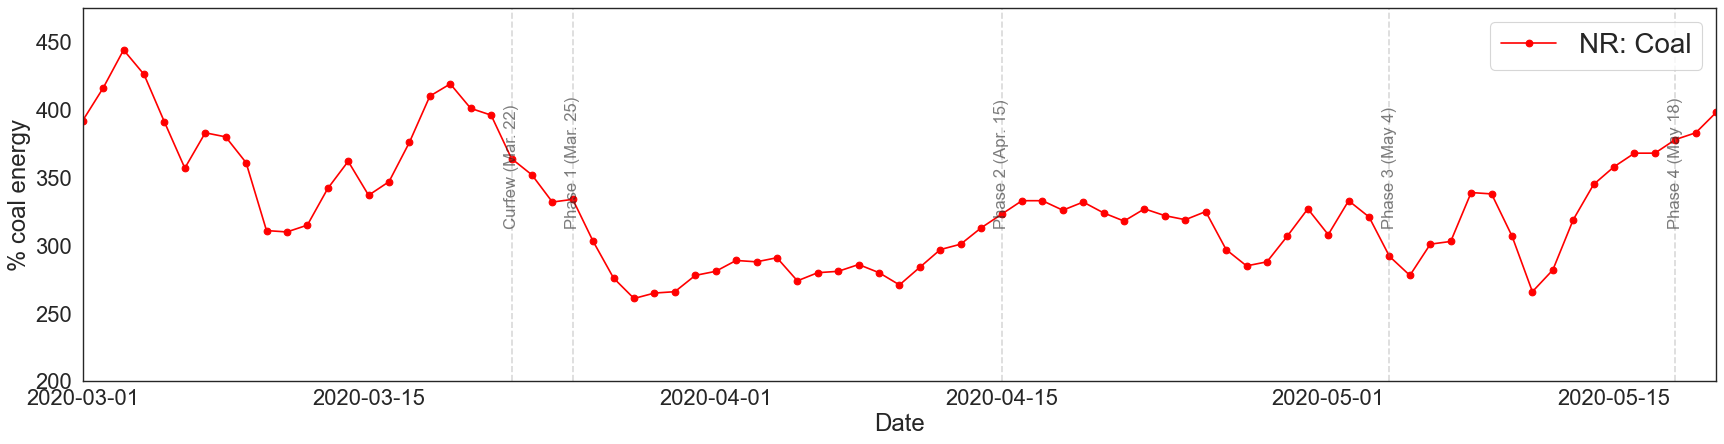

In [3]:
# plot the mean and annual trends


SAVEPATH = os.path.join(currdir, "Plots", "NCR", "CoalEnergy_20200515.png"  )

%matplotlib inline
sns.set(font_scale=1.8)
sns.set_style("white")


df_AQ = df_GM
YLIM_L = 200
YLIM_U = 500
YLABEL = "% coal energy"
SPECIES1 = 'workplaces_percent_change_from_baseline'
#SPECIES2 = 'retail_and_recreation_percent_change_from_baseline'
Curfew = datetime.datetime(2020, 3, 22)
Lockdown1 = datetime.datetime(2020, 3, 25)
Lockdown2 = datetime.datetime(2020, 4, 15)
Lockdown3 = datetime.datetime(2020, 5, 4)
Lockdown4 = datetime.datetime(2020, 5, 18)

#df_GM["sub_region_1" = "Delhi"]

df_AQ['doy'] = df_GM.index.dayofyear
df1 = df_GM.copy()

fig=plt.figure(figsize=(22, 6), dpi= 80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
cmap = plt.get_cmap ( "viridis" )

df_yy = df1

SPECIES = "NR: Coal"
x = df_yy[SPECIES].index
y = df_yy[SPECIES]
ax.plot(x,y,color = "red", marker = 'o', alpha = 1, label = SPECIES )# alpha = clearsky)

SPECIES = "SR: Coal"
x = df_yy[SPECIES].index
y = df_yy[SPECIES]
#ax.plot(x,y,color = "blue", marker = 'o', alpha = 1, label = SPECIES )# alpha = clearsky)


# region = "Haryana"
# x = df_yy[df_yy["sub_region_1"] == region].index
# y = df_yy[df_yy["sub_region_1"] == region][SPECIES1]
# ax.plot(x,y,color = "blue", marker = '^', alpha = 0.8, label = "Haryana" )# alpha = clearsky)

# region = "Uttar Pradesh"
# x = df_yy[df_yy["sub_region_1"] == region].index
# y = df_yy[df_yy["sub_region_1"] == region][SPECIES1]
# ax.plot(x,y,color = "green", marker = '>', alpha = 0.8, label = "Uttar Pradesh")# alpha = clearsky)




# ---   annotate the lockdown --- # 
arrowprops = {'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05 }

ax.axvline(Curfew, color='grey',alpha = 0.3, linestyle = '--')
ax.annotate('Curfew (Mar. 22)', xy=(Curfew, 0.6*YLIM_U), xytext=(0, 15), textcoords='offset points',
             rotation=90, va='bottom', ha='center', annotation_clip=True, alpha = 0.6, size = 15 ) # arrowprops=arrowprops,

ax.axvline(Lockdown1, color='grey',alpha = 0.3, linestyle = '--')
ax.annotate('Phase 1 (Mar. 25)', xy=(Lockdown1, 0.6*YLIM_U), xytext=(0, 15), textcoords='offset points',
             rotation=90, va='bottom', ha='center', annotation_clip=True, alpha = 0.6, size = 15 ) # arrowprops=arrowprops,

ax.axvline(Lockdown2, color='grey',alpha = 0.3, linestyle = '--')
ax.annotate('Phase 2 (Apr. 15)', xy=(Lockdown2, 0.6*YLIM_U), xytext=(0, 15), textcoords='offset points',
             rotation=90, va='bottom', ha='center', annotation_clip=True, alpha = 0.6, size = 15 ) # arrowprops=arrowprops,

ax.axvline(Lockdown3, color='grey',alpha = 0.3, linestyle = '--')
ax.annotate('Phase 3 (May 4)', xy=(Lockdown3, 0.6*YLIM_U), xytext=(0, 15), textcoords='offset points',
             rotation=90, va='bottom', ha='center', annotation_clip=True, alpha = 0.6, size = 15 ) # arrowprops=arrowprops,

ax.axvline(Lockdown4, color='grey',alpha = 0.3, linestyle = '--')
ax.annotate('Phase 4 (May 18)', xy=(Lockdown4, 0.6*YLIM_U), xytext=(0, 15), textcoords='offset points',
             rotation=90, va='bottom', ha='center', annotation_clip=True, alpha = 0.6, size = 15 ) # arrowprops=arrowprops,


plt.tick_params(axis="x", direction="inout")
plt.xlim(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 5, 20))
plt.ylim([YLIM_L,YLIM_U*0.95])
plt.ylabel(YLABEL)
plt.xlabel("Date")
#plt.title("Trend over National Capital Region for " + SPECIES)
plt.legend(loc = "upper right", ncol = 4, fontsize = 25)
plt.tight_layout()
plt.savefig(SAVEPATH, bbox_inches = "tight")



# power-plant level data
read pdf, clean and Plots. Data directly from POSOCO website

In [4]:
import PyPDF2
# pdf file object
# you can find find the pdf file with complete code in below
pdfFileObj = open("E:\OneDrive - 総合地球環境学研究所\AQM_Research\Data\Raw\PowerGeneration\POSOCO_NRLDC\daily010520.pdf", 'rb')
#"E:\OneDrive - 総合地球環境学研究所\AQM_Research\Data\Raw\PowerGeneration\POSOCO_NRLDC\daily010520.pdf"

# pdf reader object
pdfReader = PyPDF2.PdfFileReader(pdfFileObj)

# number of pages in pdf
print(pdfReader.numPages)

# a page object
pageObj = pdfReader.getPage(3)

# extracting text from page.
# this will print the text you can also save that into String
print(pageObj.extractText())

8
3(B)RegionalEntitiesGenerationInst.CapacityDeclaredCapacity20:0003:00DayPeakDayEnergyStation/Constituents(MW)(MW)PeakMWOffPeakMW(MW)HrsSCHD(MU)ACT(MU)AVG.MWUIAravaliPowerCompanyPrivateLtdISTPP(JHAJJAR)(3*500)1,5001,414000-0--0Sub-Total1,5001,41400--0000BBMBBHAKRAHPS(2*108+3*126+5*157)1,3791,1541,1746881,17420:0020.0320.078360.04DEHARHPS(6*165)99064081033081020:0011.411.654850.25PONGHPS(6*66)3963043106631020:005.625.722380.1Sub-Total2,7652,0982,2941,084--37.0537.441,5590.39NHPCBAIRASIULHPS(3*60)18012011911912014:002.672.821180.15CHAMERAHPS(3*180)54055553653553709:0010.1110.174240.06CHAMERAIIHPS(3*100)30010010010010109:002.352.38990.03CHAMERAIIIHPS(3*77)23124022215723321:003.733.771570.04DHAULIGANGAHPS(4*70)280292272028121:002.862.931220.07DULHASTIHPS(3*130)39040539239940313:009.29.293870.09KISHANGANGA(3*110)33022222211022322:003.23.251350.05PARBATIIIIHEP(4*130)520520499052519:451.611.63680.02PARBATI-II(2*400)(Infirm)800-64396420:00-1.02431.02SALALHPS(6*115)69063067157070109:0014.2814.

In [5]:
# ref 
# https://medium.com/@umerfarooq_26378/python-for-pdf-ef0fac2808b0
import tabula

# create a dictionary to store the page number to use and the official name of the pweor plant
# create this dictionary by reading the pdf as df and identifying manually
dict_PP =dict()
#                     pg num, official name, field name, column number of daily energy
dict_PP["DadriTPP"] = [4, "DADRI-IITPS( 2 * 490 )", "Unnamed: 7" ]
dict_PP["HarduaganjTPP"] = [3, "HARDUAGANJTPS( 1 * 105 + 1 * 60 + 2 *\r250 )",  "Unnamed: 5" ]
dict_PP["PanipatTPP1"] = [2, "PANIPATTPS( 1 * 210 + 2 * 250 )", "Unnamed: 6" ]
dict_PP["PanipatTPP2"] = [2, "PANIPATTPS( 2 * 210 + 2 * 250 )", "Unnamed: 5" ]
dict_PP["JhajjarTPP"] = [2, "JHAJJAR(CLP)( 2 * 660 )", "Unnamed: 5" ]
dict_PP["IGSTPP"] = [4, "ISTPP (JHAJJAR)( 3 * 500 )", "Unnamed: 7" ]

# readinf the PDF file that contain Table Data
# you can find find the pdf file with complete code in below
# read_pdf will save the pdf table into Pandas Dataframe

# report downloaded from https://nrldc.in/reports/daily-reports/daily-regional-power-supply-position/

def getEnergySimple(dict_PP, PPName):
    # simpllae func to read pdf
    # # this is valid for reports generated after 2018 08 30. Previous reports had another format
    fileName = "daily210520.pdf"
    fileName = os.path.join( "Data", "Emission", "DailyPower", "daily080520.pdf")
    officialName = dict_PP[PPName][1]
    fieldNameEnergy = dict_PP[PPName][2]
    df = tabula.read_pdf(fileName,multiple_tables=True, pages = page)[0]
    fieldNamePP = df.columns[0]
    energyMU = df[df[fieldNamePP]== officialName][fieldNameEnergy].values[0]
    #fileName = os.path.join("Data", "daily080520.pdf")
    #E:/OneDrive - 総合地球環境学研究所\\AQM_Research\\Data\\Raw\\PowerGeneration\\POSOCO_NRLDC\\daily080520.pdf'                        
    #"E:\OneDrive - 総合地球環境学研究所\AQM_Research\Data\Raw\PowerGeneration\POSOCO_NRLDC\daily080520.pdf"


2019-01-01 18.78
error
2020-01-01 12.77
2019-02-01 15.59
error
2020-02-01 13.27
2019-03-01 5.94
error
2020-03-01 12.5
2019-04-01 6.77
error
2020-04-01 5.98
error
2019-05-01 12.22
2020-05-01 6.01
error
2019-06-01 14.86
2020-06-01 5.82
error
2019-07-01 17.31
2020-07-01 7.42
error
2019-08-01 13.14


Got stderr: Sep 01, 2020 1:45:06 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 1:45:06 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 1:45:08 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 1:45:08 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 1:45:09 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-01 XXX
error
2019-09-01 5.86
error
2019-10-01 6.18
error
2019-11-01 6.86
error
2019-12-01 6.29
2019-01-02 18.88
error
2020-01-02 13.1
2019-02-02 17.69
error
2020-02-02 12.61
2019-03-02 8.19
error
2020-03-02 12.84
2019-04-02 7.93
error
2020-04-02 5.97
error
2019-05-02 11.03
2020-05-02 5.87
error
2019-06-02 15.96
2020-06-02 5.88
error
2019-07-02 17.18
2020-07-02 12.76
error
2019-08-02 14.46


Got stderr: Sep 01, 2020 1:45:46 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 1:45:47 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored
Sep 01, 2020 1:45:47 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 1:45:47 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored
Sep 01, 2020 1:45:48 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 1:45:48 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenT

error


Got stderr: Sep 01, 2020 1:45:49 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-02 XXX
error
2019-09-02 5.84
error
2019-10-02 6.09
error
2019-11-02 6.62
error
2019-12-02 6.43
2019-01-03 19.18
error
2020-01-03 13.36
2019-02-03 17.58
error
2020-02-03 15.89
2019-03-03 7.91
error
2020-03-03 13.12
2019-04-03 7.44
error
2020-04-03 5.99
error
2019-05-03 13.06
2020-05-03 5.91
error
2019-06-03 13.16
2020-06-03 5.91
error
2019-07-03 15.44
2020-07-03 11.84
error
2019-08-03 13.9
2020-08-03 6.22
error
2019-09-03 6.85
error
2019-10-03 6.43
error
2019-11-03 6.49
error
2019-12-03 6.4
error


error again
2019-01-04 XXX
error
2020-01-04 12.86
2019-02-04 17.24
error
2020-02-04 15.3
2019-03-04 8.37
error
2020-03-04 13.1
2019-04-04 8.39
error
2020-04-04 5.98
error
2019-05-04 12.65
2020-05-04 5.95
error
2019-06-04 14.68
2020-06-04 5.92
error
2019-07-04 17.4
2020-07-04 11.95
error
2019-08-04 14.85
2020-08-04 6.14
error
2019-09-04 6.2
error
2019-10-04 6.51
error
2019-11-04 11.32
error
2019-12-04 5.35
2019-01-05 18.76
error
2020-01-05 12.82
2019-02-05 17.96
error
2020-02-05 14.8
2019-03-05 8.28
error
2020-03-05 12.61
2019-04-05 6.9
error
2020-04-05 5.98
error
2019-05-05 13.4
2020-05-05 5.84
error
2019-06-05 18.25
2020-06-05 5.6
error
2019-07-05 13.71
2020-07-05 8.7
error
2019-08-05 13.7
2020-08-05 5.81
error
2019-09-05 6.28
error
2019-10-05 6.1
error
2019-11-05 6.82
error
2019-12-05 6.24
2019-01-06 15.76
error
2020-01-06 13.18
2019-02-06 14.58
error
2020-02-06 14.03
2019-03-06 8.16
error
2020-03-06 12.76
2019-04-06 10.72
error
2020-04-06 5.98
2019-05-06 13.35
2020-05-06 5.85
error


Got stderr: Sep 01, 2020 2:02:19 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 2:02:20 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 2:02:20 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored



error again
2020-08-01 XXX
error
2019-09-01 11.1
error
2019-10-01 nan
error
2019-11-01 6.9
error
2019-12-01 6.6
2019-01-02 9.31
error
2020-01-02 11.02
2019-02-02 nan
error
2020-02-02 6.73
2019-03-02 7.59
error
2020-03-02 6.54
2019-04-02 8.29
error
2020-04-02 nan
error
2019-05-02 7.29
2020-05-02 3.55
error
2019-06-02 9.15
2020-06-02 7.25
error
2019-07-02 5.25
2020-07-02 10.2
error
2019-08-02 12.2


Got stderr: Sep 01, 2020 2:02:52 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 2:02:53 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 2:02:53 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored
Sep 01, 2020 2:02:54 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 2:02:54 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored
Sep 01, 2020 2:02:55 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 2:02:55 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenT

error again
2020-08-02 XXX
error
2019-09-02 12.3
error
2019-10-02 0
error
2019-11-02 7.2
error
2019-12-02 7
2019-01-03 9.57
error
2020-01-03 9.22
2019-02-03 nan
error
2020-02-03 7.29
2019-03-03 6.24
error
2020-03-03 6.5
2019-04-03 4.21
error
2020-04-03 nan
error
2019-05-03 7.75
2020-05-03 3.2
error
2019-06-03 7.99
2020-06-03 8.9
error
2019-07-03 5.2
2020-07-03 9.9
error
2019-08-03 12.1
2020-08-03 8.1
error
2019-09-03 12.4
error
2019-10-03 nan
error
2019-11-03 8.41
error
2019-12-03 6.82
error
error again
2019-01-04 XXX
error
2020-01-04 9.99
2019-02-04 nan
error
2020-02-04 8.2
2019-03-04 6.45
error
2020-03-04 6.14
2019-04-04 4.8
error
2020-04-04 nan
error
2019-05-04 10.2
2020-05-04 3.4
error
2019-06-04 9.6
2020-06-04 7.9
error
2019-07-04 5
2020-07-04 9.4
error
2019-08-04 9
2020-08-04 7.6
error
2019-09-04 12.43
error
2019-10-04 1.27
error
2019-11-04 8.76
error
2019-12-04 7.01
2019-01-05 10.2
error
2020-01-05 8.5
2019-02-05 nan
error
2020-02-05 8.1
2019-03-05 6.5
error
2020-03-05 5.1
2019-

Got stderr: Sep 01, 2020 2:18:33 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 2:18:35 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-01 XXX
error
error again
2019-09-01 XXX
error
error again
2019-10-01 XXX
error
error again
2019-11-01 XXX
error
error again
2019-12-01 XXX
error
error again
2019-01-02 XXX
error
error again
2020-01-02 XXX
error
error again
2019-02-02 XXX
error
error again
2020-02-02 XXX
error
error again
2019-03-02 XXX
error
error again
2020-03-02 XXX
error
error again
2019-04-02 XXX
error
error again
2020-04-02 XXX
error
error again
2019-05-02 XXX
2020-05-02 4.79
error
error again
2019-06-02 XXX
2020-06-02 nan
error
error again
2019-07-02 XXX
2020-07-02 10.54
error
error again
2019-08-02 XXX


Got stderr: Sep 01, 2020 2:19:13 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 2:19:14 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-02 XXX
error
error again
2019-09-02 XXX
error
error again
2019-10-02 XXX
error
error again
2019-11-02 XXX
error
error again
2019-12-02 XXX
error
error again
2019-01-03 XXX
error
error again
2020-01-03 XXX
error
error again
2019-02-03 XXX
error
error again
2020-02-03 XXX
error
error again
2019-03-03 XXX
error
error again
2020-03-03 XXX
error
error again
2019-04-03 XXX
error
error again
2020-04-03 XXX
error
error again
2019-05-03 XXX
2020-05-03 3.57
error
error again
2019-06-03 XXX
2020-06-03 nan
error
error again
2019-07-03 XXX
2020-07-03 10.74
error
error again
2019-08-03 XXX
2020-08-03 5.39
error
error again
2019-09-03 XXX
error
error again
2019-10-03 XXX
error
error again
2019-11-03 XXX
error
error again
2019-12-03 XXX
error
error again
2019-01-04 XXX
error
error again
2020-01-04 XXX
error
error again
2019-02-04 XXX
error
error again
2020-02-04 XXX
error
error again
2019-03-04 XXX
error
error again
2020-03-04 XXX
error
error again
2019-04-04 XXX
error
error again


Got stderr: Sep 01, 2020 2:37:01 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 2:37:02 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-01 XXX
2019-09-01 9.55
2019-10-01 4.98
2019-11-01 nan
2019-12-01 nan
2019-01-02 18.57
2020-01-02 7.36
2019-02-02 9.83
2020-02-02 nan
2019-03-02 nan
2020-03-02 3.07
2019-04-02 9.69
2020-04-02 nan
2019-05-02 9.88
error
error again
2020-05-02 XXX
2019-06-02 9.48
error
error again
2020-06-02 XXX
2019-07-02 10.01
error
error again
2020-07-02 XXX
2019-08-02 nan


Got stderr: Sep 01, 2020 2:37:28 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 2:37:29 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-02 XXX
2019-09-02 9.73
2019-10-02 4.9
2019-11-02 nan
2019-12-02 nan
2019-01-03 18.55
2020-01-03 4.85
2019-02-03 9.59
2020-02-03 nan
2019-03-03 nan
2020-03-03 4.56
2019-04-03 9.95
2020-04-03 nan
2019-05-03 9.73
error
error again
2020-05-03 XXX
2019-06-03 9.47
error
error again
2020-06-03 XXX
2019-07-03 10.21
error
error again
2020-07-03 XXX
2019-08-03 nan
error
error again
2020-08-03 XXX
2019-09-03 9.71
2019-10-03 8.05
2019-11-03 nan
2019-12-03 nan
error
error again
2019-01-04 XXX
2020-01-04 4.71
2019-02-04 9.76
2020-02-04 nan
2019-03-04 nan
2020-03-04 3.4
2019-04-04 10.11
2020-04-04 nan
2019-05-04 8.39
error
error again
2020-05-04 XXX
2019-06-04 8.3
error
error again
2020-06-04 XXX
2019-07-04 9.69
error
error again
2020-07-04 XXX
2019-08-04 nan
error
error again
2020-08-04 XXX
2019-09-04 9.92
2019-10-04 9.58
2019-11-04 nan
2019-12-04 nan
2019-01-05 10.38
2020-01-05 4.76
2019-02-05 9.93
2020-02-05 nan
2019-03-05 nan
2020-03-05 nan
2019-04-05 10.06
2020-04-05 nan
2019

Got stderr: Sep 01, 2020 2:49:41 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 2:49:42 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-01 XXX
2019-09-01 20.28
2019-10-01 20.15
2019-11-01 nan
2019-12-01 8.95
2019-01-02 22.52
2020-01-02 19.16
2019-02-02 24.2
2020-02-02 17.89
2019-03-02 18.36
2020-03-02 12.12
2019-04-02 13.58
2020-04-02 nan
2019-05-02 16.57
2020-05-02 nan
2019-06-02 20.29
2020-06-02 nan
2019-07-02 21.35
2020-07-02 nan
2019-08-02 24.66


Got stderr: Sep 01, 2020 2:50:02 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 2:50:03 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-02 XXX
2019-09-02 21.95
2019-10-02 18.48
2019-11-02 nan
2019-12-02 10.3
2019-01-03 24.81
2020-01-03 20.22
2019-02-03 20.98
2020-02-03 19.75
2019-03-03 17.86
2020-03-03 18.5
2019-04-03 10.58
2020-04-03 nan
2019-05-03 9.09
2020-05-03 nan
2019-06-03 19.83
2020-06-03 nan
2019-07-03 24.9
2020-07-03 nan
2019-08-03 19.22
2020-08-03 nan
2019-09-03 26.31
2019-10-03 21.84
2019-11-03 nan
2019-12-03 10.18
error
error again
2019-01-04 XXX
2020-01-04 19.68
2019-02-04 23.86
2020-02-04 21.63
2019-03-04 18.38
2020-03-04 21.21
2019-04-04 10.94
2020-04-04 nan
2019-05-04 9.2
2020-05-04 nan
2019-06-04 20.4
2020-06-04 nan
2019-07-04 21.36
2020-07-04 nan
2019-08-04 19.88
2020-08-04 nan
2019-09-04 21.37
2019-10-04 18.21
2019-11-04 nan
2019-12-04 10.42
2019-01-05 21.7
2020-01-05 18.75
2019-02-05 23.72
2020-02-05 23.62
2019-03-05 20.91
2020-03-05 19.1
2019-04-05 10.63
2020-04-05 nan
2019-05-05 9.37
2020-05-05 nan
2019-06-05 21.29
2020-06-05 nan
2019-07-05 19.51
2020-07-05 23:00
2019-08-05 23

Got stderr: Sep 01, 2020 3:00:27 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 3:00:27 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored



error


Got stderr: Sep 01, 2020 3:00:28 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 3:00:29 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 3:00:30 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-01 XXX
error
2019-09-01 18.86
error
2019-10-01 -
error
2019-11-01 10.24
error
2019-12-01 12.52
2019-01-02 19.37
error
2020-01-02 7.3
2019-02-02 25.2
error
2020-02-02 6.16
2019-03-02 23.28
error
2020-03-02 13.12
2019-04-02 6.73
error
2020-04-02 -
error
2019-05-02 6.21
2020-05-02 -
error
2019-06-02 15.87
2020-06-02 0
error
2019-07-02 22.7
2020-07-02 13.24
error
2019-08-02 -


Got stderr: Sep 01, 2020 3:01:02 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 3:01:02 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored
Sep 01, 2020 3:01:03 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 3:01:03 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F3 are not implemented in PDFBox and will be ignored
Sep 01, 2020 3:01:03 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored
Sep 01, 2020 3:01:03 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenT

error


Got stderr: Sep 01, 2020 3:01:04 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font CIDFont+F1 are not implemented in PDFBox and will be ignored



error again
2020-08-02 XXX
error
2019-09-02 19.03
error
2019-10-02 0
error
2019-11-02 6.45
error
2019-12-02 13.52
2019-01-03 17.59
error
2020-01-03 7.45
2019-02-03 24.04
error
2020-02-03 7.91
2019-03-03 20.21
error
2020-03-03 13.44
2019-04-03 0.01
error
2020-04-03 -
error
2019-05-03 6.35
2020-05-03 -
error
2019-06-03 14.04
2020-06-03 -
error
2019-07-03 20.25
2020-07-03 12.54
error
2019-08-03 0.3
2020-08-03 0.15
error
2019-09-03 22.41
error
2019-10-03 0
error
2019-11-03 6.36
error
2019-12-03 13.19
error
error again
2019-01-04 XXX
error
2020-01-04 7.03
2019-02-04 25.11
error
2020-02-04 7.5
2019-03-04 23
error
2020-03-04 11.81
2019-04-04 0.01
error
2020-04-04 0
error
2019-05-04 6.37
2020-05-04 -
error
2019-06-04 7.5
2020-06-04 -
error
2019-07-04 17.14
2020-07-04 12.64
error
2019-08-04 0.22
2020-08-04 6.09
error
2019-09-04 16.06
error
2019-10-04 0.18
error
2019-11-04 12.64
error
2019-12-04 14.46
2019-01-05 13.51
error
2020-01-05 6.4
2019-02-05 27.16
error
2020-02-05 7.41
2019-03-05 23.52
e

In [1]:


def getEnergy(fileName, dict_PP, PPName):
    # read the pdf
    # NOTE # this is valid for reports generated after 2018 08 30. Previous reports had another format
    officialName = dict_PP[PPName][1]
    fieldNameEnergy = dict_PP[PPName][2]
    
    try:
        # read the pdf as df
        page = dict_PP[PPName][0]
        df = tabula.read_pdf(fileName,multiple_tables=True, pages = page)[0]
        #print(df)
        # get the name of the first column
        fieldNamePP = df.columns[0]
        # print the value 
        energyMU = df[df[fieldNamePP]== officialName][fieldNameEnergy].values[0]
        #print(df)
    
    # theremay be error because page ordering is not always consistent. experiment with the next page
    except (IndexError, KeyError): 
        print("error")
        
        try:
            # read the pdf as df
            page = dict_PP[PPName][0]+1
            df = tabula.read_pdf(fileName,multiple_tables=True, pages = page)[0]
            
            # get the name fo the first columns
            fieldNamePP = df.columns[0]
            # print the value 
            energyMU = df[df[fieldNamePP]== officialName][fieldNameEnergy].values[0]
            #print(df)
        except:
            print("error again")
            return "XXX"
        
    #print (energyMU)
    #df[df["3(B)Regional Entities Generation"]=="DADRI-IITPS( 2 * 490 )"]["Unnamed: 7"]
    
    return energyMU


def ParallelgetEnergy(fileName):
    
    date = "20" + fileName[-6:-4]+ "-" + fileName[-8:-6]+ "-" + fileName[-10:-8]
    
    if int(fileName[-6:-4]) >=19:
        # read the pdf
        # NOTE # this is valid for reports generated after 2018 08 30. Previous reports had another format
        officialName = dict_PP[PPName][1]
        fieldNameEnergy = dict_PP[PPName][2]

        try:
            # read the pdf as df
            page = dict_PP[PPName][0]
            df = tabula.read_pdf(fileName,multiple_tables=True, pages = page)[0]
            #print(df)
            # get the name of the first column
            fieldNamePP = df.columns[0]
            # print the value 
            energyMU = df[df[fieldNamePP]== officialName][fieldNameEnergy].values[0]
            #print(df)

        # theremay be error because page ordering is not always consistent. experiment with the next page
        except (IndexError, KeyError): 
            print("error")

            try:
                # read the pdf as df
                page = dict_PP[PPName][0]+1
                df = tabula.read_pdf(fileName,multiple_tables=True, pages = page)[0]

                # get the name fo the first columns
                fieldNamePP = df.columns[0]
                # print the value 
                energyMU = df[df[fieldNamePP]== officialName][fieldNameEnergy].values[0]
                #print(df)
            except:
                print("error again")
                return [date, "XXX"]


        #print (energyMU)
        #df[df["3(B)Regional Entities Generation"]=="DADRI-IITPS( 2 * 490 )"]["Unnamed: 7"]

        return [date, energyMU]
    else:
        return


#run for one pwer plant
def saveEnergycsv(PPName):
    ls = []
    for fileName in glob(os.path.join( "Data", "Emission", "DailyPower", "daily*.pdf")):
        date = "20" + fileName[-6:-4]+ "-" + fileName[-8:-6]+ "-" + fileName[-10:-8]
        #print(fileName)
        
        if int(fileName[-6:-4]) >=19:
            # only run for the data after 20190101
        
            energyMU = getEnergy(fileName, dict_PP, PPName)
            print(date, energyMU)
            ls.append([date, energyMU])

    df_PP = pd.DataFrame(ls, columns=["date", "energu(MU)"])
    df_PP.to_csv("DayEnergy_"+PPName + ".csv")
    # not needed currently
    # can also convert to excel csv 
    #abula.convert_into("daily210520.pdf", "offense_testing.csv", output_format="csv", pages = page)

def ParallelsaveEnergycsv():
    #pool = mp.Pool(processes=4)
    ls = []
    fileList = glob(os.path.join( "Data", "Emission", "DailyPower", "daily*.pdf"))
    ls = map(ParallelgetEnergy, fileList)
    df_PP = pd.DataFrame(ls, columns=["date", "energy(MU)"])
    df_PP.to_csv("DayEnergy_"+PPName + ".csv")


In [ ]:
PPName = "DadriTPP"
rpp.saveEnergycsv(PPName)

PPName = "HarduaganjTPP"
rpp.saveEnergycsv(PPName)

PPName = "PanipatTPP1"
rpp.saveEnergycsv(PPName)

PPName = "PanipatTPP2"
rpp.saveEnergycsv(PPName)

PPName = "JhajjarTPP"
rpp.saveEnergycsv(PPName)

PPName = "IGSTPP"
rpp.saveEnergycsv(PPName)
#ParallelsaveEnergycsv()

In [11]:
PPName = "IGSTPP"
fileName = "daily210520.pdf"
fileName = os.path.join( "Data", "Emission", "DailyPower", "daily010120.pdf")
page = dict_PP[PPName][0]
officialName = dict_PP[PPName][1]

fieldNameEnergy = dict_PP[PPName][2]
df = tabula.read_pdf(fileName,multiple_tables=True, pages = page)[0]
fieldNamePP = df.columns[0]
df[df[fieldNamePP]==officialName]["Unnamed: 7"]#.values[0]

3    6.68
Name: Unnamed: 7, dtype: object

In [7]:
df

,3(B)Regional Entities Generation,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Station/Constituents,Inst.\rCapacity,Declared Capacity,19:00,03:00,Day Peak,Day Energy,AVG. MW,UI,NaN,NaN
1,NaN,(MW),(MW),Peak MW,Off Peak\rMW,(MW),Hrs,SCHD\r(MU),ACT (MU),NaN,NaN
2,Aravali Power Company Private Ltd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ISTPP (JHAJJAR)( 3 * 500 ),"1,500",942.5,285,289,503,10:55,6.72,6.68,278,-0.04
4,Sub-Total,"1,500",942.5,285,289,-,-,6.72,6.68,278,-0.04
5,BBMB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,BHAKRA HPS( 2 * 108 + 3 * 126\r+ 5 * 157 ),"1,379","1,119","1,136",413,"1,136",19:00,14.85,15.02,626,0.17
7,DEHARHPS( 6 * 165 ),990,465,480,0,480,19:00,3.11,3.22,134,0.11
8,PONGHPS( 6 * 66 ),396,188,192,192,192,19:00,3.99,4.03,168,0.04
9,Sub-Total,"2,765","1,772","1,808",605,-,-,21.95,22.27,928,0.32
